# Denoising Speech with NLMS and KLMS Adaptive Filters
*Ian Malone*

### Project Description

The purpose of this project is to design and evaluate the performance of a machine learning algorithm using the normalized LMS algorithm (or one of its variants) that will clean the desired input (speech plus noise) from the machine noise (input). This is an example of the interference canceling problem explained below.

Speech data is collected in a noisy room (loud vacuum cleaner) by two microphones: one on a table that captures speech with the vacuum cleaner noise (d(n)) and the other very close to the vacuum cleaner (n(n)) that basically has no speech. Even if you listen to d(n), the speech is barely audible, and the message is not understandable. The goal is to denoise d(n) and be able to understand the speech. It is suggested to use the signal n(n) as the input to the LMS algorithm and use d(n) as the desired response. 

### Project Steps

Start with a 2-tap filter:

 - Plots of the performance surface contours for the two weights filter case.
 - Plot the weight tracks
 - Plot the learning curve and interpret it.
 - Estimate the frequency response from the desired signal to the error when the filter is adapted.
 - Estimate the SNR improvement in dB by: 
    $ERLE=10\log(\frac{E[d^{2}]}{E[e^{2}]})$
    
Increase the filter order based on an analysis of performance. Explain your choice for the filter order.

 - Estimate again the frequency response from the desired signal to the error.
 - Compute the SNR improvement in dB
 - Evaluate the filter performance as a function of the stepsize.
 - Estimate the misadjustment.
 - Comment on the results obtained and address issues related to the convergence of the algorithm in nonstationary environments.
 
You can use a FIR filter, a gamma filter or the KLMS to compare performance. 

### Project Implementation

In [1]:
# Import libraries
# mark

import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
%load_ext autotime

time: 0 ns (started: 2021-03-09 08:53:31 -05:00)


In [2]:
class NLMS():
    
    def __init__(self, step_size=0.4, order=2):
        self.step_size = step_size
        self.order = order
        
    def learn(self, u, d):

        # initialize
        f = np.zeros(len(d))
        e = np.zeros(len(d))
        w = np.random.rand(self.order)
        w_trk = np.zeros((len(d)-self.order, self.order))

        # compute
        for i in range(1, len(d)-self.order):
            y = np.dot(w,u[i:i+self.order])
            e[i] = d[i+self.order] - y
            norm = ((np.linalg.norm(u[i:i+self.order])) ** 2)+0.1
            w = w + (self.step_size * e[i] * u[i])/norm   #normalize the step by the power of the input
            f[i] = y
            w_trk[i] = w 
        return f, w_trk, e


class GaussianKernel:
    def kernel(self, a, b):
        numer = (np.linalg.norm(a - b)) ** 2
        denom = (2 * self.sigma ** 2)
        return np.exp(-1 * (numer / denom))
    
    
class KLMS(GaussianKernel):
    
    def __init__(self, step_size=0.4, sigma=1, order=3): 
        self.step_size = step_size
        self.sigma = sigma
        self.order = order
       
    
    def learn(self, input_signal, desired_signal):
        # initialize
        estimates = np.zeros(len(input_signal))
        coefficients = np.zeros(len(input_signal))
        errors = np.zeros(len(input_signal))
        coefficients[0] = self.step_size * desired_signal[0]

        # compute
        for i in range(1, len(input_signal)-self.order):
            estimates[i-1] = 0
            for j in range(i-1):
                partial_sum = coefficients[j] * self.kernel(input_signal[i:i+(self.order-1)], input_signal[j:j+(self.order-1)])
                estimates[i-1] += partial_sum                 

            errors[i] = desired_signal[i+self.order] - estimates[i-1]
            coefficients[i] = self.step_size * errors[i]
        
        return estimates, coefficients, errors
    
    
    
    
    
    
    
#         for i in range(1, len(input_signal)-self.order):

#             estimates[i-1] = 
        
        
        
        
        
#        def predict(self, new_input):
#         estimate = 0
#         for i in range(0, len(self.weights)):
#             addition = self.weights[i] * self.kernel(self.inputs[i], new_input)
#             estimate += addition
#         return estimate

#     def update(self, new_input, expected):
#         self.error = expected - self.predict(new_input)
#         self.inputs.append(new_input)
#         new_weights = self.learning_step * self.error
#         self.weights.append(new_weights)     
        
        
#             %training
#     ii = 1:n-1;
#     y(n) = lr_k*e_k(ii)'*(exp(-sum((X(:,n)*ones(1,n-1)-X(:,ii)).^2)))';
#     e_k(n) = T(n) - y(n);
        
        

time: 16 ms (started: 2021-03-09 08:53:31 -05:00)


#### Test the NLMS and KLMS on a Noisy Sine Wave

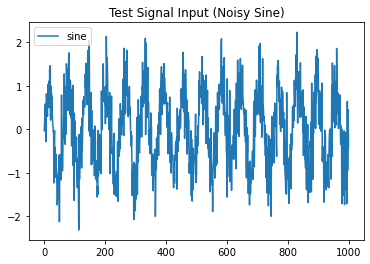

time: 141 ms (started: 2021-03-09 08:53:31 -05:00)


In [3]:
time = np.arange(0,100,0.1)
noisy_sine = np.sin(time)+np.random.normal(0,0.5,size=len(time))
plt.plot(noisy_sine, label='sine')

plt.title('Test Signal Input (Noisy Sine)')
plt.legend(loc='upper left')

In [4]:
nlms_test = NLMS(step_size=0.8, order=2)

time: 0 ns (started: 2021-03-09 08:53:31 -05:00)


In [5]:
output_test_n, weights_test_n, error_test_n = nlms_test.learn(noisy_sine, noisy_sine)

time: 16 ms (started: 2021-03-09 08:53:31 -05:00)


In [6]:
klms_test = KLMS(step_size=0.2, sigma=2, order=3)

time: 0 ns (started: 2021-03-09 08:53:31 -05:00)


In [7]:
output_test_k, weights_test_k, error_test_k = klms_test.learn(noisy_sine, noisy_sine)

time: 4.14 s (started: 2021-03-09 08:53:31 -05:00)


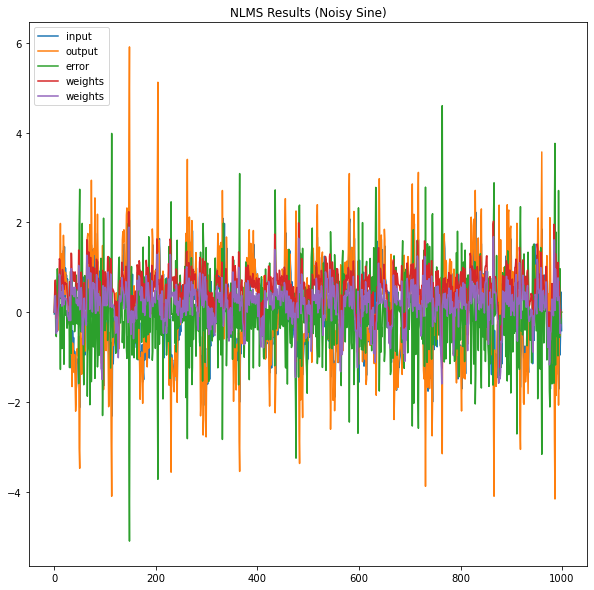

time: 172 ms (started: 2021-03-09 08:53:36 -05:00)


In [8]:
plt.figure(figsize=(10,10))

plt.plot(noisy_sine, label='input')
plt.plot(output_test_n, label='output')
plt.plot(error_test_n, label='error')
plt.plot(weights_test_n, label='weights')

plt.title('NLMS Results (Noisy Sine)')
plt.legend(loc="upper left")

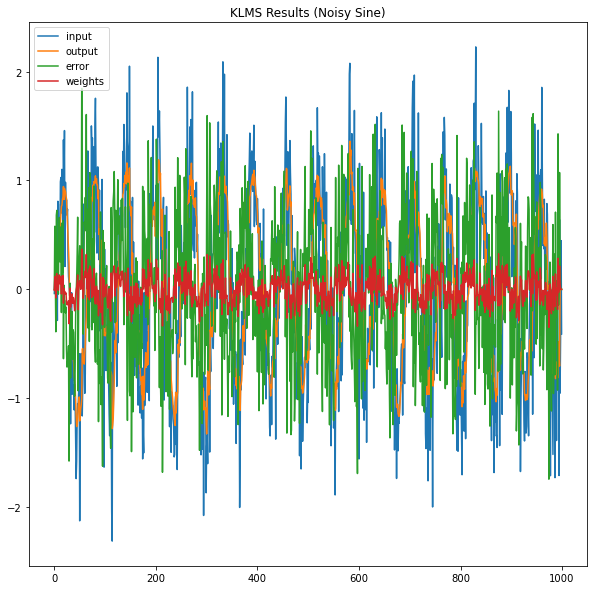

time: 156 ms (started: 2021-03-09 08:53:36 -05:00)


In [9]:
plt.figure(figsize=(10,10))

plt.plot(noisy_sine, label='input')
plt.plot(output_test_k, label='output')
plt.plot(error_test_k, label='error')
plt.plot(weights_test_k, label='weights')

plt.title('KLMS Results (Noisy Sine)')
plt.legend(loc="upper left")

#### Apply the NLMS and KLMS FIlters to the Noisy Speech Signal

In [10]:
# The .mat file contains two channels with data labeled as desired (d) and input (n). 

filepath = 'C:\\Users\\Ian\\Google Drive\\IanGMalone\\UF\\Classes\\ML Time Series\\Projects\\Project1\\project1.mat'
mat_data = scipy.io.loadmat(filepath)
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'fs', 'primary', 'reference'])
time: 15 ms (started: 2021-03-09 08:53:36 -05:00)


In [11]:
fs = int(mat_data['fs'][0])
# u is mostly noise input
# d is speech + noise desired
# error will be denoised speech

u = np.asarray(mat_data['primary'])[0,:]
d = np.asarray(mat_data['reference'])[0,:]

time: 0 ns (started: 2021-03-09 08:53:36 -05:00)


In [12]:
ipd.Audio(d[:35000], rate=fs) # load a NumPy array

time: 125 ms (started: 2021-03-09 08:53:36 -05:00)


Text(0.5, 1.0, 'Primary and Reference Signals')

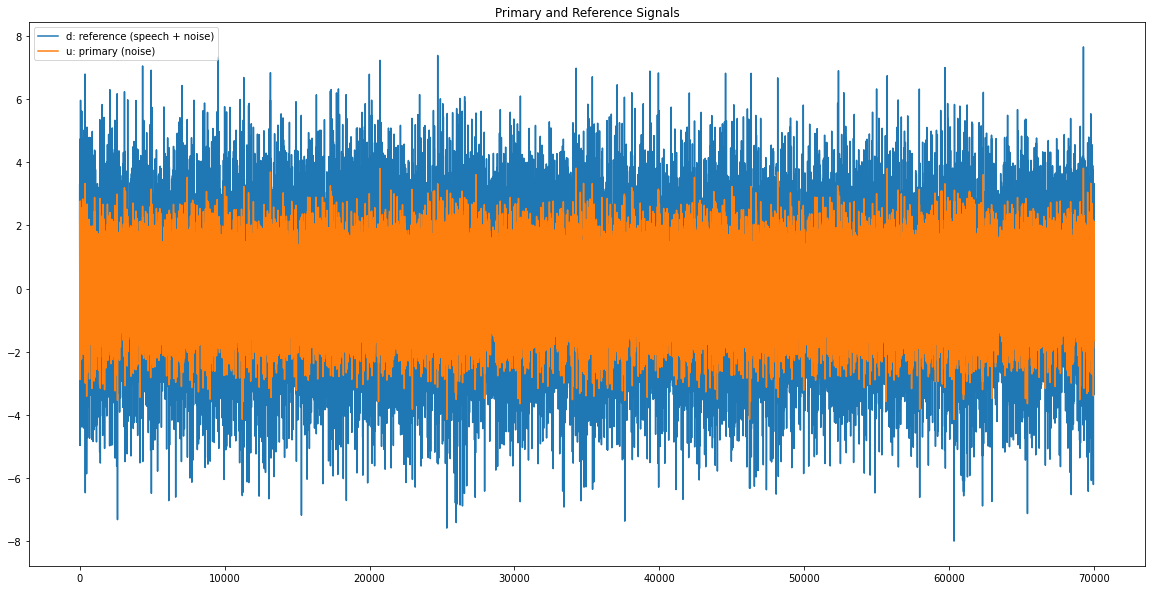

time: 484 ms (started: 2021-03-09 08:53:36 -05:00)


In [13]:
plt.figure(figsize=(20,10))

plt.plot(d, label='d: reference (speech + noise)')
plt.plot(u, label='u: primary (noise)')

plt.legend(loc="upper left")
plt.title('Primary and Reference Signals')

#### Compute upper bound of NLMS step size

In [14]:
"The maximum step size is %s." % (0.1*2*(np.var(u)))     

'The maximum step size is 0.21408459274580527.'

time: 0 ns (started: 2021-03-09 08:53:37 -05:00)


In [15]:
np.matrix(u[:50]).getH

<bound method matrix.H of matrix([[ 2.176516  ,  1.61199169,  1.1259992 ,  0.63495345, -0.61443169,
         -1.52709304, -0.91152031,  0.66154369,  0.64738617, -0.3158902 ,
         -0.04896743, -0.11659474, -1.6023851 , -2.13553842, -1.44588971,
         -1.16594611, -0.89194027, -0.78944328, -1.64471839, -2.53139112,
         -2.77686741, -2.87637905, -2.03723198, -0.78155962, -0.72892331,
         -1.45337962, -2.06384176, -1.90598185, -0.81216105,  0.46753837,
          1.0525515 ,  1.10565869,  1.24331064,  0.5087503 , -0.01538247,
          1.21237953,  2.07162398,  2.46478543,  2.77462956,  2.06375576,
          0.8938489 ,  0.09515303,  0.44103224,  0.98006557,  0.96192537,
          1.0886684 ,  0.40310866, -0.711882  , -1.22779488, -1.37408027]])>

time: 0 ns (started: 2021-03-09 08:53:37 -05:00)


In [16]:
from scipy import signal

# corr_matrix = signal.correlate(u,u)
corr_matrix = np.cov(u,u)
corr_matrix.trace()

2.140876511408215

time: 47 ms (started: 2021-03-09 08:53:37 -05:00)


In [17]:
nlms = NLMS(step_size=0.1, order=3)

time: 0 ns (started: 2021-03-09 08:53:37 -05:00)


In [18]:
output_n, weights_n, error_n = nlms.learn(u,d)

time: 641 ms (started: 2021-03-09 08:53:37 -05:00)


In [19]:
klms = KLMS(step_size=0.1, sigma=1, order=2)

time: 0 ns (started: 2021-03-09 08:53:37 -05:00)


In [20]:
output_k, weights_k, error_k = klms.learn(u[55000:60000],d[55000:60000])

time: 1min 42s (started: 2021-03-09 08:53:37 -05:00)


In [21]:
# 100 -> 0.047 s
# 1000 -> 4.5 s
# 10000 -> 6m47s
# 70000 -> 

time: 0 ns (started: 2021-03-09 08:55:20 -05:00)


(-10.0, 10.0)

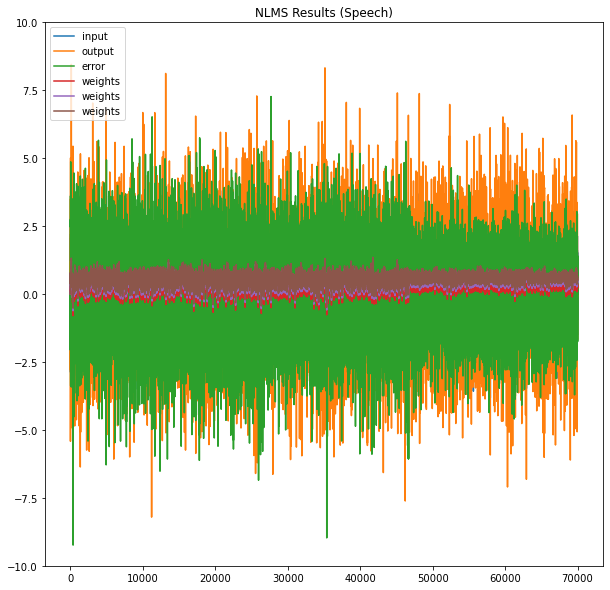

time: 484 ms (started: 2021-03-09 08:55:20 -05:00)


In [22]:
plt.figure(figsize=(10,10))

plt.plot(u, label='input')
plt.plot(output_n, label='output')
plt.plot(error_n, label='error')
plt.plot(weights_n, label='weights')

plt.title('NLMS Results (Speech)')
plt.legend(loc="upper left")
plt.ylim([-10,10])

(-10.0, 10.0)

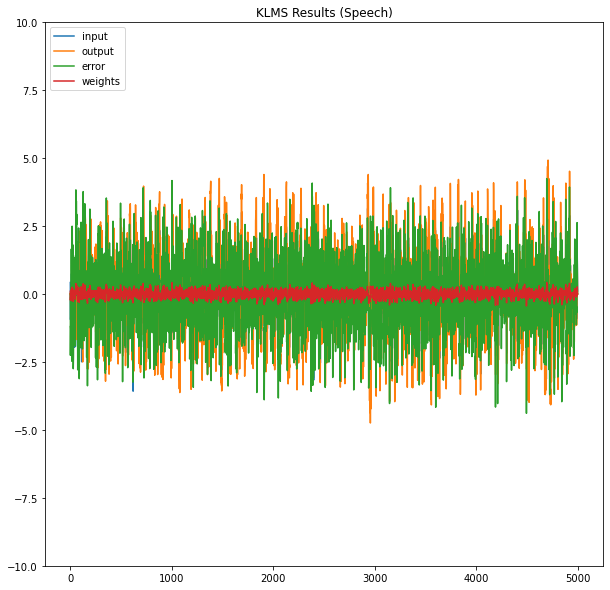

time: 188 ms (started: 2021-03-09 08:55:20 -05:00)


In [23]:
plt.figure(figsize=(10,10))

plt.plot(u[55000:60000], label='input')
plt.plot(output_k, label='output')
plt.plot(error_k, label='error')
plt.plot(weights_k, label='weights')

plt.title('KLMS Results (Speech)')
plt.legend(loc="upper left")
plt.ylim([-10,10])

In [24]:
a = d-u
ipd.Audio(a, rate=fs) # load a NumPy array

time: 0 ns (started: 2021-03-09 08:55:20 -05:00)


In [25]:
b = d-output_n
ipd.Audio(b, rate=fs) # load a NumPy array

time: 0 ns (started: 2021-03-09 08:55:20 -05:00)


In [26]:
c = d[55000:60000]-output_k
ipd.Audio(a, rate=fs) # load a NumPy array

time: 0 ns (started: 2021-03-09 08:55:20 -05:00)


#### Create a 2-tap NLMS filter and choose parameters

In [27]:
reps = 10
steps = [0.01,0.05,0.1,0.5,1,2,5]
MSE = np.zeros((reps, len(steps)))

for i in range(reps):
    for j in range(len(steps)):
        nlms_two_tap = NLMS(step_size=steps[j], order=2)
        output_n, weights_n, error_n = nlms.learn(u,d)
        MSE[i,j] = (np.mean(error_n[-500:]**2))

MSE.mean(axis=0)

array([1.79067501, 1.71689235, 1.2207939 , 2.10625597, 2.1201602 ,
       1.81716202, 2.02763823])

time: 45.8 s (started: 2021-03-09 08:55:20 -05:00)


The best order-2 NLMS filter of those tested uses a step size of 2.

#### Plot the performance surface contours for this filter

In [77]:
nlms_two_tap = NLMS(step_size=2, order=2)
outputs_n, weights_n, error_n = nlms_two_tap.learn(u[10000:20000],d[10000:20000])
weights_n = weights_n[1:]
errors_n = error_n[1:-2]

time: 94 ms (started: 2021-03-09 09:22:51 -05:00)


<ipython-input-99-d0c54f9a97a1>:18: RuntimeWarning: invalid value encountered in sqrt
  axes.contour(a, b, np.sqrt(a-b)**2)


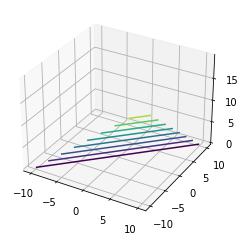

time: 594 ms (started: 2021-03-09 09:29:57 -05:00)


In [99]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 
  
a = weights_n[:,0]
b = weights_n[:,1] 
  
a, b = np.meshgrid(a, b) 
  
# surface plot for a**2 + b**2 
a = np.arange(-10, 10, 0.02) 
b = a 
a, b = np.meshgrid(a, b) 
  
fig = plt.figure(figsize=(4,4)) 
axes = fig.gca(projection ='3d') 
axes.contour(a, b, np.sqrt(a-b)**2) 
  
plt.show() 


# def nlms_perf_surf(d, y):
#     return np.sqrt((d-y)**2)              
                        
# # define vectors
# x = weights_n[:,0]
# y = weights_n[:,1]
# z = nlms_perf_surf(d[10003:20000], outputs_n[3:])
                   
# # make 3D surface plot
# fig = plt.figure(figsize =(10,10)) 
# ax = plt.axes(projection ='3d') 
# ax.plot_trisurf(x, y, z, linewidth=0, antialiased=False)

# # look at lms/nlms slides... first slide has "simple estimate of performance surface"

#### Plot the weight tracks

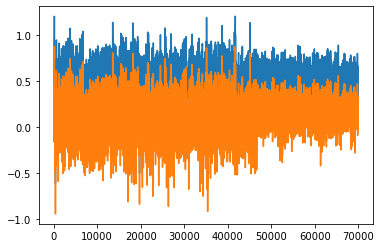

time: 141 ms (started: 2021-03-09 09:00:27 -05:00)


In [52]:
weights_1 = weights_n[:,0]
weights_2 = weights_n[:,1]

plt.plot(weights_1)
plt.plot(weights_2)


#### Plot the learning curve

C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


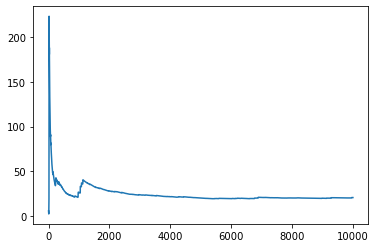

time: 188 ms (started: 2021-03-09 08:56:06 -05:00)


In [31]:
def learning_curve(errors):
    curve = []
    for i in range(len(errors)):
        curve.append(np.mean(errors[:i]**2))
    return curve


### might need to make this ensemble averaged (and explain that in the methods)


plt.plot(learning_curve(errors_n))

#### Estimate the frequency response

Text(0.5, 1.0, 'This is a plot from the SciPy docs with dummy data')

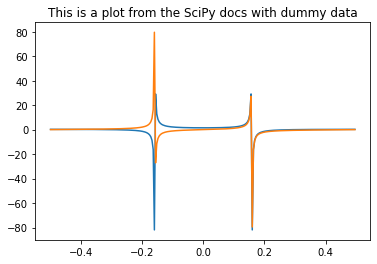

time: 93 ms (started: 2021-03-09 09:10:55 -05:00)


In [75]:
# frequency response of a system is H=Y/X... FFT(error)/FFT(desired)
# may have to do fft shift to make symmetric

from scipy.fft import fft, fftfreq, fftshift
H = scipy.fft.fft(errors_n)/scipy.fft.fft(d[10003:20000]) # correct way to calculate the frequency response?
    
    
    
# # this code is copied from SciPy docs
# t = np.arange(len(errors_n))
# sp = fftshift(fft(scipy.fft.fft(errors_n)/scipy.fft.fft(d[10003:20000])))
# freq = fftshift(fftfreq(t.shape[-1]))
# plt.plot(freq, sp.real, freq, sp.imag)

t = np.arange(256)
sp = fftshift(fft(np.sin(t)))
freq = fftshift(fftfreq(t.shape[-1]))
plt.plot(freq, sp.real, freq, sp.imag)
plt.title('This is a plot from the SciPy docs with dummy data')

C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'FFT of the desired signal')

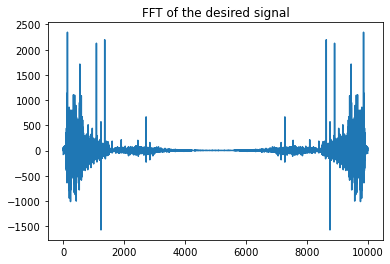

time: 109 ms (started: 2021-03-09 09:07:42 -05:00)


In [69]:
plt.plot(scipy.fft.fft(d[10003:20000]))
plt.title('FFT of the desired signal')

C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'FFT of the errors')

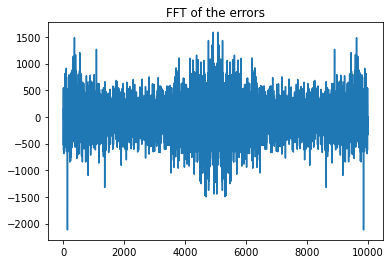

time: 109 ms (started: 2021-03-09 09:07:58 -05:00)


In [70]:
plt.plot(scipy.fft.fft(errors_n))
plt.title('FFT of the errors')

C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Is this the correct estimated frequency response?')

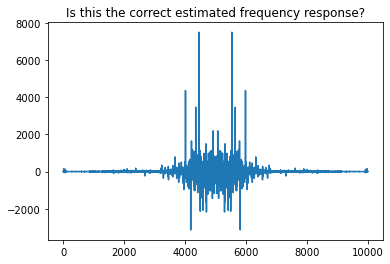

time: 94 ms (started: 2021-03-09 09:07:31 -05:00)


In [68]:
plt.plot(scipy.fft.fft(errors_n)/scipy.fft.fft(d[10003:20000]))
plt.title('Is this the correct estimated frequency response?')

#### Estimate SNR improvement in dB

In [33]:
def ERLE(d, e):
    return float(10*np.log10(sum(d**2)/sum(e**2)))

print(ERLE(d, errors_n))

1.5218595272345024
time: 0 ns (started: 2021-03-09 08:56:07 -05:00)


#### Increase filter order

In [34]:
# search for a better performing filter order

reps = 10
orders = [2,3,4,5,6,7,8,9,10]
MSE = np.zeros((reps, len(orders)))
ERLEs = np.zeros((reps, len(orders)))

for i in range(reps):
    for j in range(len(orders)):
        nlms_two_tap = NLMS(2, order=orders[j])
        output_n, weights_n, error_n = nlms.learn(u,d)
        MSE[i,j] = (np.mean(error_n[-500:]**2))
        ERLEs[i,j] = ERLE(d, error_n)

print(MSE.mean(axis=0))
print(ERLEs.mean(axis=0))

[1.5667767  1.59976132 2.09153502 1.7668836  1.86158544 1.77766784
 1.79661504 1.51843256 1.4014085 ]
[3.18333306 3.20597082 2.35548117 2.87383861 2.69766889 2.89641978
 2.93788393 3.36412518 3.57719199]
time: 1min (started: 2021-03-09 08:56:07 -05:00)


The highest performing filter is order-3.

#### Find a good step size for this order filter

In [35]:
# search for highest performing step size

reps = 10
steps = [0.01,0.05,0.1,0.5,1,2,5]
MSE = np.zeros((reps, len(steps)))

for i in range(reps):
    for j in range(len(steps)):
        nlms_two_tap = NLMS(step_size=steps[j], order=3)
        output_n, weights_n, error_n = nlms.learn(u,d)
        MSE[i,j] = (np.mean(error_n[-500:]**2))

MSE.mean(axis=0)

array([1.3278234 , 1.48547928, 1.78722912, 1.37515503, 1.72024478,
       1.69344853, 1.78244305])

time: 45.7 s (started: 2021-03-09 08:57:07 -05:00)


The best step size of those tested is 0.05.

In [36]:
# estimate new frequency response

# !!!!!!!!!!! add

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [37]:
# compute snr improvement in db

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [38]:
# evaluate filter performance as a function of step size

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [39]:
# estimate the misadjustment

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [40]:
# comment on results obtained and address issues related to the convergence of thealgorithms in nonstationary environemnts

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


#### Implement a better filter, KLMS

In [41]:
# now do klms...
# 2 tap grid search parameters for best performance

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [42]:
# plot weight tracks??? maybe not able to

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [43]:
# plot learning curve

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [44]:
# estimate frequency response

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [45]:
# estimate snr improvement in db

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [46]:
# increase filter order , grid search parameters

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [47]:
# estimate the frequency resopnse

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [48]:
# compute snr improvement 

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [49]:
# evaluate filter performance as a finction of stepsize

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [50]:
# estimate the misadjustment

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)


In [51]:
# Comment on the results obtained and address issues related to the convergence of the algorithm in nonstationary environments.
 

time: 0 ns (started: 2021-03-09 08:57:53 -05:00)
